<a href="https://colab.research.google.com/github/acard5meg/ece_516_final/blob/main/gan_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Based on Papers:
1. The Synthetic Data Vault: Patki, Wedge, Veeramachaneni
2. Modeling Tabular Data using Conditional GAN: Xu, Skoularidou, Cuesta-Infante, Veeramachaneni

In [1]:
%%capture
!pip install sdv

import numpy as np
import pandas as pd
from tensorflow import keras
from keras import *
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import csv
import seaborn as sns
# USED FOR GAN MODEL
import sdv
print(sdv.version.public)
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality, get_column_plot
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [2]:
# Read the data hosted on my github
%%capture
url = "https://raw.githubusercontent.com/acard5meg/ece_516_final/refs/heads/main/model/heat_stroke_data.csv"

data = pd.read_csv(url)
# shuffle data to destroy dependencies
data.sample(frac=1)

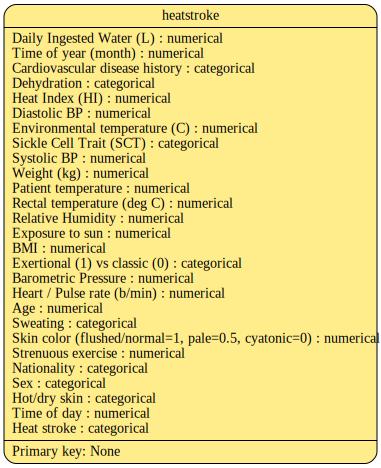

In [3]:
metadata = Metadata.detect_from_dataframe(
    data = data,
    table_name = 'heatstroke'
)
feature_metadata = Metadata.detect_from_dataframe(
    data = data[["BMI", "Age", "Relative Humidity", "Environmental temperature (C)", "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)", "Sex", "Heat stroke"]],
    table_name = 'mini_data'
)

metadata.visualize()

In [ ]:
def create_gan(disc_decay=1e-6, discr_lr=2e-4, gen_decay=1e-6, gen_lr=2e-4):
  gan_synth = CTGANSynthesizer(
      metadata = metadata,
      enforce_min_max_values = True,
      enforce_rounding = True,
      epochs = 300,
      verbose = True,
      batch_size = 500,
      discriminator_decay=disc_decay,
      discriminator_lr=discr_lr,
      generator_decay = gen_decay,
      generator_lr = gen_lr
  )

  gan_synth.fit(data)

  synthetic_data = gan_synth.sample(num_rows = 1000)

  diag_report = run_diagnostic(
    real_data = data,
    synthetic_data = synthetic_data,
    metadata = metadata,
    verbose = False
  )
  diag_df = diag_report.get_details("Data Validity")
  diag_acc = diag_df['Score'].sum() / len(diag_df)

  qual_report_feature_space = evaluate_quality(
    real_data = data[["BMI", "Age", "Relative Humidity", "Environmental temperature (C)", "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)", "Sex", "Heat stroke"]],
    synthetic_data = synthetic_data[["BMI", "Age", "Relative Humidity", "Environmental temperature (C)", "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)", "Sex", "Heat stroke"]],
    metadata = feature_metadata,
    verbose = False
  )
  col_shapes_df = qual_report_feature_space.get_details("Column Shapes")
  col_shapes_df_score = col_shapes_df['Score'].sum() / len(col_shapes_df)

  col_pairs_df = qual_report_feature_space.get_details("Column Pair Trends")
  col_pairs_df_score = col_pairs_df['Score'].sum() / len(col_pairs_df)

  final_score = (col_shapes_df_score + col_pairs_df_score) / 2

  print(final_score)
  return (final_score, gan_synth, diag_acc)



In [ ]:
l1 = [1e-6, 1e-4, 1e-8]
l2 = [2e-4, 2e-2, 2e-6]
l3 = [1e-6, 1e-4, 1e-8]
l4 = [2e-4, 2e-2, 2e-6]

def grid_search(l1, l2, l3, l4, idx1, idx2, idx3, idx4, max_score, best_model):
  if idx1 == len(l1):
    return (max_score, best_model)
  if idx2 == len(l2):
    return grid_search(l1, l2, l3, l4, idx1+1, 0, 0, 0, max_score, best_model)
  if idx3 == len(l3):
    return grid_search(l1, l2, l3, l4, idx1, idx2+1, 0, 0, max_score, best_model)
  if idx4 == len(l4):
    return grid_search(l1, l2, l3, l4, idx1, idx2, idx3+1, 0, max_score, best_model)

  model_creation = create_gan(l1[idx1], l2[idx2], l3[idx3], l4[idx4])
  score, model, diag_acc = model_creation[0], model_creation[1], model_creation[2]

  return grid_search(l1, l2, l3, l4, idx1, idx2, idx3, idx4+1, score, model) if score > max_score and diag_acc > 0.999 \
  else grid_search(l1, l2, l3, l4, idx1, idx2, idx3, idx4+1, max_score, best_model)

grid_search_final = grid_search(l1, l2, l3, l4, 0, 0, 0, 0, 0, None)
print(grid_search_final[0])
grid_search_final[1].save("best_gan_model.pkl")

Gen. (-2.43) | Discrim. (-0.18): 100%|██████████| 300/300 [00:42<00:00,  7.12it/s]


0.819044179236635


Gen. (-4.26) | Discrim. (0.34): 100%|██████████| 300/300 [01:25<00:00,  3.51it/s]


0.6488355107760511


Gen. (1.34) | Discrim. (-9.09): 100%|██████████| 300/300 [00:40<00:00,  7.36it/s]


0.7935931614821626


Gen. (-1.75) | Discrim. (0.09): 100%|██████████| 300/300 [00:42<00:00,  7.01it/s]


0.8139839410491956


Gen. (-3.20) | Discrim. (-0.57): 100%|██████████| 300/300 [01:15<00:00,  4.00it/s]


0.6281465078332185


Gen. (0.34) | Discrim. (-8.01): 100%|██████████| 300/300 [00:41<00:00,  7.28it/s]


0.8017672547853066


Gen. (-2.43) | Discrim. (-0.10): 100%|██████████| 300/300 [00:42<00:00,  7.00it/s]


0.8208311590560944


Gen. (-4.79) | Discrim. (-0.15): 100%|██████████| 300/300 [01:26<00:00,  3.49it/s]


0.5440575961179401


Gen. (0.31) | Discrim. (-7.63): 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]


0.7724115265458189


Gen. (-11.87) | Discrim. (-0.83): 100%|██████████| 300/300 [00:40<00:00,  7.39it/s]


0.8713372868851915


Gen. (0.91) | Discrim. (-0.48): 100%|██████████| 300/300 [00:49<00:00,  6.01it/s]


0.6892374395337497


Gen. (-1.83) | Discrim. (-4.45): 100%|██████████| 300/300 [00:41<00:00,  7.19it/s]


0.7972883549926879


Gen. (3.23) | Discrim. (-0.25): 100%|██████████| 300/300 [00:43<00:00,  6.86it/s]


0.8724294550790563


Gen. (0.15) | Discrim. (-0.04): 100%|██████████| 300/300 [00:47<00:00,  6.27it/s]


0.6683861718132107


Gen. (-11.15) | Discrim. (-14.63): 100%|██████████| 300/300 [00:40<00:00,  7.43it/s]


0.792181238564579


Gen. (-10.96) | Discrim. (0.04): 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]


0.8630064116899789


Gen. (6.90) | Discrim. (-0.51): 100%|██████████| 300/300 [00:49<00:00,  6.12it/s]


0.6877353084705553


Gen. (-0.97) | Discrim. (-8.85): 100%|██████████| 300/300 [00:41<00:00,  7.29it/s]


0.793838686243597


Gen. (-0.08) | Discrim. (-0.03): 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]


0.494385237256148


Gen. (-0.09) | Discrim. (-0.01): 100%|██████████| 300/300 [01:49<00:00,  2.75it/s]


0.2446391952591609


Gen. (0.75) | Discrim. (-0.15): 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]


0.7828663210495843


Gen. (-0.03) | Discrim. (-0.03): 100%|██████████| 300/300 [00:42<00:00,  7.07it/s]


0.5871615959238764


Gen. (-0.36) | Discrim. (0.09): 100%|██████████| 300/300 [01:20<00:00,  3.75it/s]


0.30572209379814097


Gen. (0.71) | Discrim. (-0.09): 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]


0.8036982269409125


Gen. (-0.05) | Discrim. (0.00): 100%|██████████| 300/300 [00:43<00:00,  6.93it/s]


0.4248154716233181


Gen. (-0.02) | Discrim. (-0.03): 100%|██████████| 300/300 [01:48<00:00,  2.77it/s]


0.2381721201060923


Gen. (0.64) | Discrim. (-0.10): 100%|██████████| 300/300 [00:42<00:00,  7.09it/s]


0.8011940171549535


Gen. (-2.03) | Discrim. (0.01): 100%|██████████| 300/300 [00:40<00:00,  7.45it/s]


0.8249471366868633


Gen. (-3.19) | Discrim. (-0.21): 100%|██████████| 300/300 [01:22<00:00,  3.63it/s]


0.6001657147250286


Gen. (0.93) | Discrim. (-8.66): 100%|██████████| 300/300 [00:42<00:00,  7.10it/s]


0.7823259074690692


Gen. (-2.15) | Discrim. (-0.16): 100%|██████████| 300/300 [00:40<00:00,  7.42it/s]


0.828829676740612


Gen. (-3.81) | Discrim. (-0.56): 100%|██████████| 300/300 [01:18<00:00,  3.80it/s]


0.5252356298709734


Gen. (0.19) | Discrim. (-6.82): 100%|██████████| 300/300 [00:43<00:00,  6.88it/s]


0.8232786251406154


Gen. (-2.94) | Discrim. (0.39): 100%|██████████| 300/300 [00:41<00:00,  7.26it/s]


0.8217435279252983


Gen. (-5.38) | Discrim. (0.15): 100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


0.5688116612462417


Gen. (0.15) | Discrim. (-7.52): 100%|██████████| 300/300 [00:42<00:00,  7.00it/s]


0.8241922959735994


Gen. (-4.59) | Discrim. (0.05): 100%|██████████| 300/300 [00:40<00:00,  7.37it/s]


0.8755872170705554


Gen. (2.08) | Discrim. (-0.00): 100%|██████████| 300/300 [00:49<00:00,  6.02it/s]


0.6918718973552909


Gen. (7.75) | Discrim. (-5.73): 100%|██████████| 300/300 [00:40<00:00,  7.35it/s]


0.7949863803670489


Gen. (-7.08) | Discrim. (0.98): 100%|██████████| 300/300 [00:40<00:00,  7.38it/s]


0.8661537767034362


Gen. (-5.08) | Discrim. (0.86): 100%|██████████| 300/300 [00:47<00:00,  6.26it/s]


0.6873559876869422


Gen. (-4.25) | Discrim. (-7.16): 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]


0.788413808109321


Gen. (-1.75) | Discrim. (-0.28): 100%|██████████| 300/300 [00:43<00:00,  6.84it/s]


0.8727571816727706


Gen. (-7.40) | Discrim. (0.11): 100%|██████████| 300/300 [00:49<00:00,  6.01it/s]


0.6803082438443051


Gen. (13.77) | Discrim. (2.00): 100%|██████████| 300/300 [00:42<00:00,  7.14it/s]


0.8064703482388142


Gen. (-0.15) | Discrim. (-0.02): 100%|██████████| 300/300 [00:42<00:00,  6.99it/s]


0.5124992378365261


Gen. (-0.06) | Discrim. (0.06): 100%|██████████| 300/300 [01:54<00:00,  2.63it/s]


0.44754437408501796


Gen. (0.74) | Discrim. (-0.11): 100%|██████████| 300/300 [00:40<00:00,  7.34it/s]


0.7913891396815691


Gen. (-0.16) | Discrim. (0.04): 100%|██████████| 300/300 [00:43<00:00,  6.89it/s]


0.55066791150598


Gen. (-0.10) | Discrim. (0.05): 100%|██████████| 300/300 [01:13<00:00,  4.06it/s]


0.4207620589180528


Gen. (0.65) | Discrim. (-0.14): 100%|██████████| 300/300 [00:42<00:00,  7.12it/s]


0.8008731729621903


Gen. (-0.08) | Discrim. (0.03): 100%|██████████| 300/300 [00:43<00:00,  6.86it/s]


0.5873254410025877


Gen. (-0.08) | Discrim. (-0.00): 100%|██████████| 300/300 [01:48<00:00,  2.76it/s]


0.24638102187129554


Gen. (0.79) | Discrim. (-0.13): 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]


0.7789769893184418


Gen. (-2.28) | Discrim. (0.15): 100%|██████████| 300/300 [00:40<00:00,  7.40it/s]


0.8353730276576645


Gen. (-4.07) | Discrim. (-0.55): 100%|██████████| 300/300 [01:26<00:00,  3.47it/s]


0.49508272405937404


Gen. (0.73) | Discrim. (-7.48): 100%|██████████| 300/300 [00:43<00:00,  6.94it/s]


0.8080439755040547


Gen. (-2.94) | Discrim. (-0.05): 100%|██████████| 300/300 [00:41<00:00,  7.24it/s]


0.8220229802467385


Gen. (-3.17) | Discrim. (-0.48): 100%|██████████| 300/300 [01:20<00:00,  3.73it/s]


0.47171483377233947


Gen. (1.33) | Discrim. (-8.02): 100%|██████████| 300/300 [00:42<00:00,  7.05it/s]


0.8349632876127082


Gen. (-2.93) | Discrim. (-0.07): 100%|██████████| 300/300 [00:40<00:00,  7.45it/s]


0.801865209392278


Gen. (-4.28) | Discrim. (0.19): 100%|██████████| 300/300 [01:24<00:00,  3.54it/s]


0.6213806608389065


Gen. (0.16) | Discrim. (-7.08): 100%|██████████| 300/300 [00:43<00:00,  6.92it/s]


0.8182036684351037


Gen. (-3.24) | Discrim. (-1.00): 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]


0.8808692982023796


Gen. (7.66) | Discrim. (0.58): 100%|██████████| 300/300 [00:50<00:00,  5.96it/s]


0.6918191794066981


Gen. (1.99) | Discrim. (-12.34): 100%|██████████| 300/300 [00:40<00:00,  7.39it/s]


0.8218950592380152


Gen. (-2.03) | Discrim. (-0.18): 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]


0.8718706148585429


Gen. (-4.91) | Discrim. (-0.33): 100%|██████████| 300/300 [00:47<00:00,  6.35it/s]


0.6919519823247697


Gen. (-0.00) | Discrim. (-3.37): 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]


0.8085662787857488


Gen. (2.60) | Discrim. (-2.07): 100%|██████████| 300/300 [00:43<00:00,  6.88it/s]


0.8699368461385816


Gen. (8.58) | Discrim. (0.79): 100%|██████████| 300/300 [00:49<00:00,  6.07it/s]


0.6807629878194295


Gen. (0.98) | Discrim. (1.71): 100%|██████████| 300/300 [00:40<00:00,  7.34it/s]


0.8310298197405193


Gen. (-0.08) | Discrim. (-0.01): 100%|██████████| 300/300 [00:40<00:00,  7.36it/s]


0.5977997839155036


Gen. (-0.16) | Discrim. (0.01): 100%|██████████| 300/300 [01:48<00:00,  2.76it/s]


0.17734360392880089


Gen. (0.60) | Discrim. (-0.14): 100%|██████████| 300/300 [00:41<00:00,  7.25it/s]


0.8038029356446417


Gen. (-0.09) | Discrim. (0.03): 100%|██████████| 300/300 [00:43<00:00,  6.94it/s]


0.6831839652671192


Gen. (-0.13) | Discrim. (0.07): 100%|██████████| 300/300 [01:14<00:00,  4.04it/s]


0.3695534337508244


Gen. (0.72) | Discrim. (-0.09): 100%|██████████| 300/300 [00:40<00:00,  7.39it/s]


0.8067974517399399


Gen. (-0.14) | Discrim. (0.04): 100%|██████████| 300/300 [00:41<00:00,  7.28it/s]


0.4953731341163151


Gen. (-0.06) | Discrim. (-0.02): 100%|██████████| 300/300 [01:49<00:00,  2.74it/s]


0.22425661092126986


Gen. (0.65) | Discrim. (-0.06): 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]


0.783202066894598
0.8808692982023796


In [4]:
gan_synth = CTGANSynthesizer.load("best_gan_model.pkl")
gan_synth.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': True,
 'locales': ['en_US'],
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.02,
 'discriminator_decay': 1e-08,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 300,
 'pac': 10,
 'cuda': True}

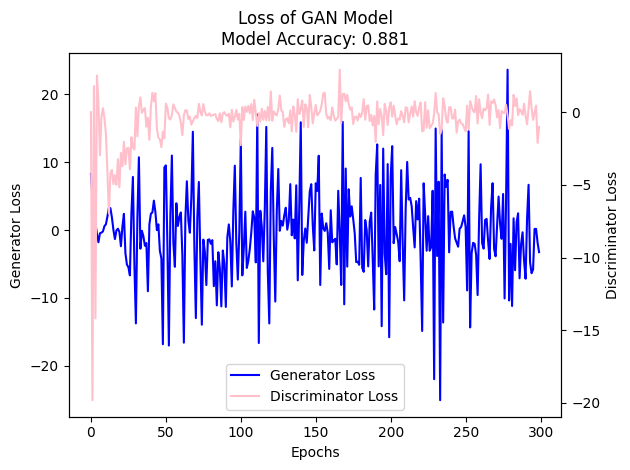

In [5]:
fig = gan_synth.get_loss_values_plot()
fig_data = fig['data']
fig_x = fig_data[0]['x']
gen_loss = fig_data[0]['y']
discr_loss = fig_data[1]['y']

fig, ax1 = plt.subplots()

ln1 = ax1.plot(fig_x, gen_loss, label = "Generator Loss", color = "Blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Generator Loss")

ax2 = ax1.twinx()

ln2 = ax2.plot(fig_x, discr_loss, label = "Discriminator Loss", color = "Pink")

ax2.set_ylabel("Discriminator Loss")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=8)
plt.title(f"Loss of GAN Model\nModel Accuracy: {grid_search_final[0]:.3f}")
plt.tight_layout()
plt.savefig("gan_model_loss.jpg")
plt.show()

In [ ]:
synthetic_data = gan_synth.sample(num_rows = 3000)

def synth_compare_plots(column):

  plot = get_column_plot(
      real_data = data,
      synthetic_data = synthetic_data,
      metadata = metadata,
      column_name = column
  )

  to_return = plot.data
  return (to_return[0].x, to_return[0].y, to_return[1].y)


### Compare feature distributions

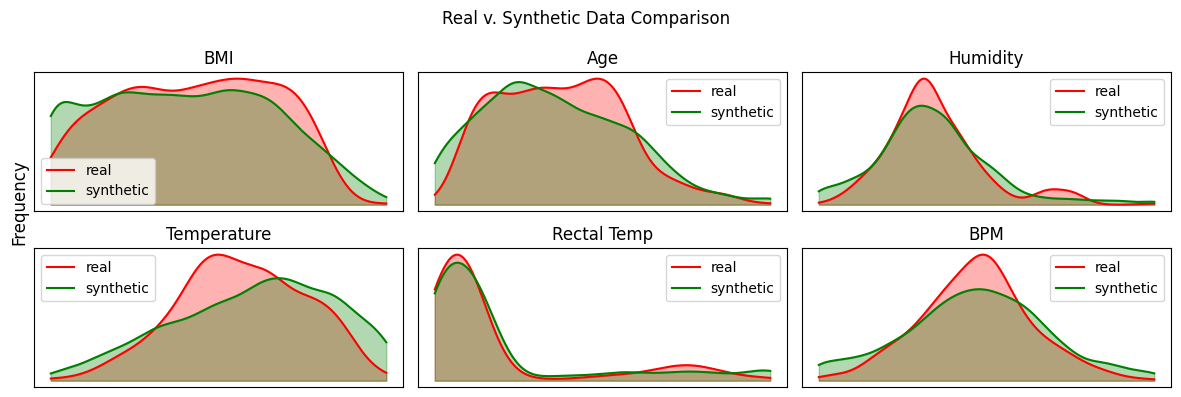

In [ ]:
fig_checks = ["BMI", "Age", "Relative Humidity", "Environmental temperature (C)", "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)"]
titles = ["BMI", "Age", "Humidity", "Temperature", "Rectal Temp", "BPM"]

fig, ax = plt.subplots(2, 3, figsize=(12,4))

curr_fig = 0
for i in range(0, 2):
  for j in range(0, 3):
    if curr_fig == len(fig_checks):
      continue
    x_axis, y_0, y_1 = synth_compare_plots(fig_checks[curr_fig])
    ax[i,j].plot(x_axis, y_0, color = 'r', label = "real")
    ax[i,j].plot(x_axis, y_1, color = 'g', label = "synthetic")
    ax[i,j].fill_between(x_axis, y_0, alpha = 0.3, color = 'red')
    ax[i,j].fill_between(x_axis, y_1, alpha = 0.3, color = 'green')
    ax[i,j].set_title(titles[curr_fig])
    ax[i,j].legend()
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    curr_fig += 1
fig.suptitle("Real v. Synthetic Data Comparison")
fig.supylabel('Frequency')
plt.tight_layout()
plt.savefig("real_v_synth_data_comp.jpg")
plt.show()

### Compare label frequency

In [ ]:
plot = get_column_plot(
  real_data = data,
  synthetic_data = synthetic_data,
  metadata = metadata,
  column_name = "Heat stroke"
)

In [ ]:
real_data_labels = np.asarray(plot.data[0]['x'])
synthetic_data_labels = np.asarray(plot.data[1]['x'])

In [ ]:
# 0,1
_, freq_real_labels = np.unique(real_data_labels, return_counts = True)

In [ ]:
_, freq_synth_labels = np.unique(synthetic_data_labels, return_counts = True)

In [ ]:
to_chart_real = freq_real_labels/np.sum(freq_real_labels)
print(to_chart_real)
to_chart_synth = freq_synth_labels/np.sum(freq_synth_labels)
print(to_chart_synth)

[0.82101806 0.17898194]
[0.78033333 0.21966667]


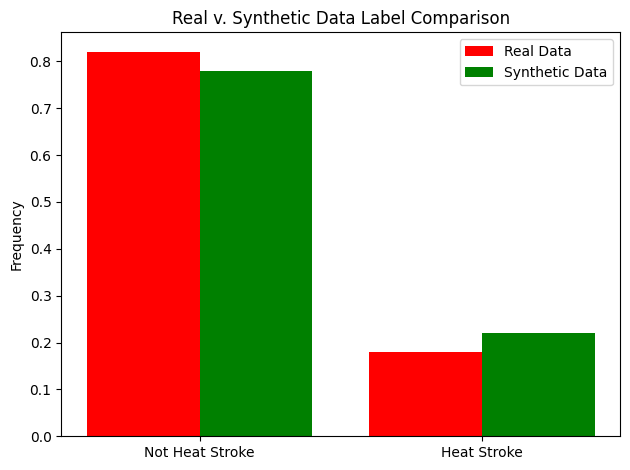

In [ ]:
X_bar_plot = ["Not Heat Stroke","Heat Stroke"]
X_axis = np.arange(2)

plt.bar(X_axis - 0.2, to_chart_real, 0.4, label = 'Real Data', color='red')
plt.bar(X_axis + 0.2, to_chart_synth, 0.4, label = 'Synthetic Data', color='green')

plt.xticks(X_axis, X_bar_plot)
plt.ylabel("Frequency")
plt.title("Real v. Synthetic Data Label Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("real_v_synth_label_comp.jpg")
plt.show()